In [7]:
pip install -U langchain-tavily

Note: you may need to restart the kernel to use updated packages.


In [8]:
from dotenv import load_dotenv

In [9]:
load_dotenv()

True

In [ ]:
from langchain_tavily import TavilySearch

tool = TavilySearch(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

{'query': "What's a 'node' in LangGraph?",
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'Nodes and Edges | langchain-ai/langgraph-101 | DeepWiki',
   'url': 'https://deepwiki.com/langchain-ai/langgraph-101/2.2-nodes-and-edges',
   'content': 'Nodes and Edges | langchain-ai/langgraph-101 | DeepWiki Nodes and Edges Nodes and Edges What are Nodes and Edges? In LangGraph, a graph is composed of nodes connected by edges to form a directed workflow. Nodes are the workhorses of LangGraph - they are Python functions that receive the current graph state as input, perform operations, and return updates to that state. Edges define the flow of execution between nodes in a LangGraph. graph_builder.add_edge("retrieve_documents", "generate_response") Conditional edges use a function to determine the next node based on the current state. Building a Graph with Nodes and Edges graph_builder.add_node("retrieve_documents", retrieve_documents) graph_builder.add_edge(

In [21]:
from IPython.display import display_markdown

def get_search_results(query: str):
    """Get search results for a given query."""
    raw_response=tool.invoke(query)
    for i in raw_response['results']:
        display_markdown(i['content'], raw=True)

    print(raw_response)

In [ ]:
get_search_results("Can you give me news about Iran?")

{'title': 'Iran | Latest News from Iran Today | AP News - Associated Press News', 'url': 'https://apnews.com/hub/iran', 'content': 'Iran These surreal trees survived for centuries. It’s also about Hamas and Iran Trump says the US and Iran have ‘sort of’ agreed on the terms for a nuclear deal Iran says it’ll continue nuclear talks with US, shrugging off Trump threats The negotiations have reached the “expert” level, meaning the sides are trying to reach agreement on the details of a possible deal. But a major sticking point remains Iran’s enrichment of uranium, which Tehran insists it must be allowed to do and the Trump administration increasingly insists the Islamic Republic must give up. For one family, 3 generations of service were defined by it Iran and US conclude a fourth round of negotiations over Tehran’s nuclear program in Oman Trump’s trip to Saudi Arabia raises the prospect of US nuclear cooperation with the kingdom Iran and US to meet in Oman for more talks on Tehran’s advan

In [ ]:

get_search_results("iran war")

Israel on Tuesday said it will "respond forcefully" to Iran's ceasefire violation after Tehran launched a fresh barrage of missiles on the Jewish state hours after both warning enemies agreed to US President Donald Trump's ceasefire proposal. Iranian media on Tuesday said an overnight Israeli strike on the north of the country killed nine people, ahead of US President Donald Trump's announcement of the start of a ceasefire between Israel and Iran. Israel and Iran on Tuesday accepted a ceasefire plan proposed by U.S. President Donald Trump to end their 12-day war that roiled the Middle East, after Tehran launched a retaliatory limited missile attack on a U.S. military base in Qatar.

Israel Iran War LIVE Updates: While US President Donald Trump declared a temporary ceasefire between the two countries, Iran's foreign minister said there was no agreement on any ceasefire or cessation of military operations. Image 28: Israel Iran War LIVE Updates: 'They don’t know what the f*** they are doing!' says Trump **Israel Iran War LIVE Updates:**Israel and Iran have agreed to the ceasefire proposed by the United States President Donald Trump on June 24. ### Israel Iran War LIVE Updates: Israel do not drop those bombs, says Donald Trump ### Israel Iran War LIVE Updates: Israel do not drop those bombs, says Donald Trump ### Israel Iran War LIVE Updates: Nine Iranians killed in Israeli strikes ### Israel Iran War LIVE Updates: Don't violate ceasefire, says Trump

{'query': 'iran war', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'title': 'Israel Iran War LIVE | Iran Attacks Israel LIVE Update | Israel Iran ...', 'url': 'https://www.ndtv.com/world-news/israel-iran-war-live-updates-us-president-donald-trump-announces-ceasefire-between-israel-and-iran-tehran-reject-truce-tel-aviv-news-8744764', 'content': 'Israel on Tuesday said it will "respond forcefully" to Iran\'s ceasefire violation after Tehran launched a fresh barrage of missiles on the Jewish state hours after both warning enemies agreed to US President Donald Trump\'s ceasefire proposal. Iranian media on Tuesday said an overnight Israeli strike on the north of the country killed nine people, ahead of US President Donald Trump\'s announcement of the start of a ceasefire between Israel and Iran. Israel and Iran on Tuesday accepted a ceasefire plan proposed by U.S. President Donald Trump to end their 12-day war that roiled the Middle East, after Tehran launched a r

In [25]:
import os
from langchain.chat_models import init_chat_model

os.environ["OPENAI_API_KEY"] = "sk-..."

llm = init_chat_model("groq:llama-3.1-70b-versatile")

In [28]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

# Modification: tell the LLM which tools it can call
# highlight-next-line
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

In [29]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

In [30]:
def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()


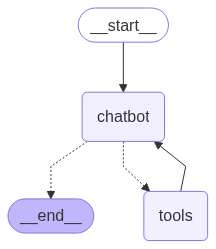

In [31]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

In [1]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [2]:
graph = graph_builder.compile(checkpointer=memory)

NameError: name 'graph_builder' is not defined

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass